In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=704cba852db8f007431eeed38c943e95c09abfa8a8f4e064ef9cee5845ce436f
  Stored in directory: /root/.cache/pip/wheels/7a/68/21/675239322d2bb2e8e1fa317d4bd7b5566a4e82780b25a27f7a
Successfully built pykalman


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/700
12/12 [==============================] - 3s 78ms/step - loss: 0.2436 - lr: 0.0100
Epoch 2/700
12/12 [==============================] - 1s 70ms/step - loss: 0.0112 - lr: 0.0100
Epoch 3/700
12/12 [==============================] - 1s 70ms/step - loss: 0.0072 - lr: 0.0100
Epoch 4/700
12/12 [==============================] - 1s 72ms/step - loss: 0.0070 - lr: 0.0100
Epoch 5/700
12/12 [==============================] - 1s 75ms/step - loss: 0.0051 - lr: 0.0100
Epoch 6/700
12/12 [==============================] - 1s 77ms/step - loss: 0.0057 - lr: 0.0100
Epoch 7/700
12/12 [==============================] - 1s 78ms/step - loss: 0.0067 - lr: 0.0100
Epoch 8/700
12/12 [==============================] - 1s 76ms/step - loss: 0.0064 - lr: 0.0100
Epoch 9/700
12/12 [==============================] - 1s 71ms/step - loss: 0.0057 - lr: 0.0100
Epoch 10/700
12/12 [==============================] - 1s 71ms/step - loss: 0.0062 - lr: 0.0100
Epoch 11/700
12/12 [==============================] - 1s 71

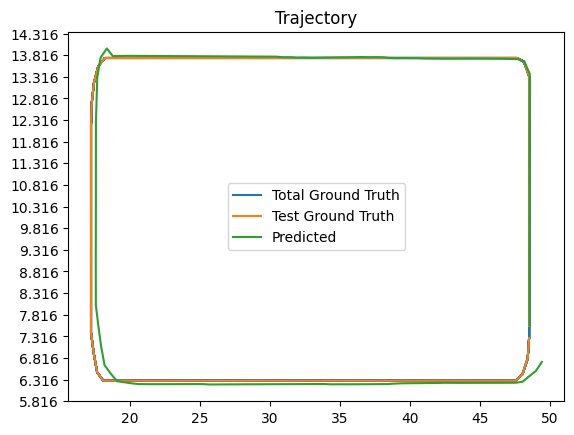

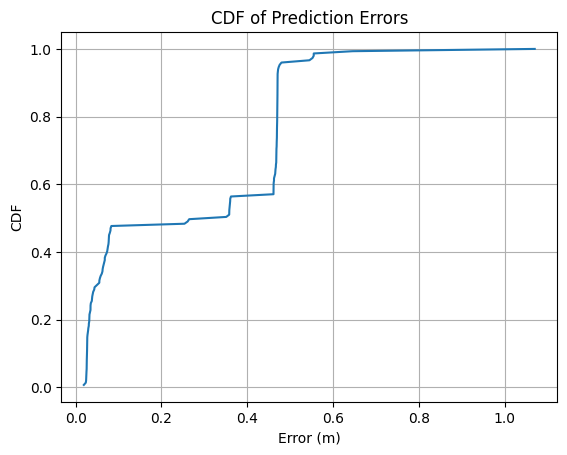

Mean squared error: 0.0013260573009699383


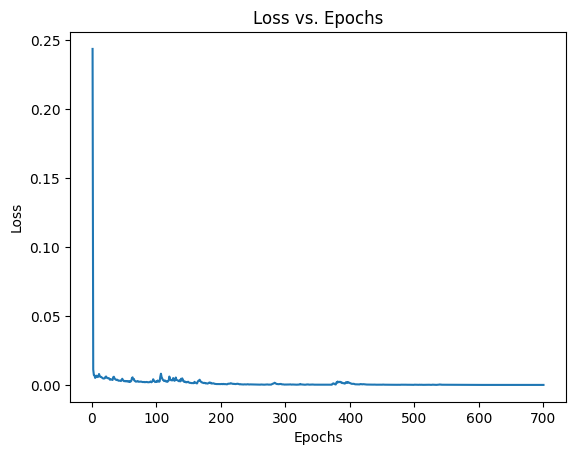

In [ ]:
########################################################################### 单圈Test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import LambdaCallback, LearningRateScheduler  # 添加回调库和动态learning rate
from keras.optimizers import Adam  # 添加优化器库
# from pykalman import KalmanFilter  # 卡尔曼滤波器


# 数据处理器
def process_data(data_file):
    data = pd.read_csv(data_file)
    imu_data = data.iloc[:, 2:11].values
    label_data = data.iloc[:, 14:16].values  
    label_data_delta = data.iloc[:, 17:19].values  
    imu_data = np.reshape(imu_data, (-1, 1100, 9))
    label_data = np.reshape(label_data, (-1, 2))
    label_data_delta = np.reshape(label_data_delta, (-1, 2))
    return imu_data, label_data, label_data_delta



# 添加用于绘制CDF图的函数
def plot_cdf(predictions, ground_truth):
    errors = np.sqrt(np.sum((predictions - ground_truth)**2, axis=1))
    sorted_errors = np.sort(errors)
    p = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, p)
    plt.xlabel('Error (m)')
    plt.ylabel('CDF')
    plt.title('CDF of Prediction Errors')
    plt.grid()
    plt.savefig('CDF_of_Prediction_Errors.png', dpi=300)  # 保存图像
    plt.show()


# 添加学习率调度器
def scheduler(epoch):
    if epoch < 200:
        return 0.01
    if epoch < 400:
        return 0.0075
    if epoch < 600:
        return 0.004
    else:
        return 0.001
    # else:
        # return 0.01 - 0.0015 * (epoch // 100)

# 创建带有学习率调度器的优化器
optimizer = Adam(lr=0.01)
lr_scheduler = LearningRateScheduler(scheduler)

# LSTM模型
def build_model(input_shape=(1100, 9), output_shape=2, dropout_rate=0.05):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    # model.add(Dropout(dropout_rate))
    model.add(LSTM(64))
    # model.add(Dropout(dropout_rate))
    model.add(Dense(output_shape, activation='linear'))
    # odel.compile(loss='mse', optimizer='adam')

    # 添加学习率
    # learning_rate = 0.0005
    # optimizer = Adam(lr=learning_rate)  # 创建带有自定义学习率的优化器
    # model.compile(loss='mse', optimizer=optimizer)  # 使用带有自定义学习率的优化器
    # return model


    model.compile(loss='mse', optimizer=optimizer)  # 使用带有学习率调度器的优化器
    return model

# 定义一个回调函数，用于记录每个epoch的loss
def on_epoch_end(epoch, logs):
    epoch_losses.append(logs['loss'])
#  初始化一个列表，用于存储每个epoch的loss
epoch_losses = []



# 主函数
def main():
    # 数据处理


    #data_file = '/content/drive/MyDrive/Colab Notebooks/processed_data_foot1.csv'
    #imu_data, label_data, label_data_delta = process_data(data_file)

    #data_file = '/content/drive/MyDrive/Colab Notebooks/processed_data_hand.csv'
    #imu_data, label_data, label_data_delta = process_data(data_file)

    data_file = '/content/drive/MyDrive/Colab Notebooks/processed_data_pocket.csv'
    imu_data, label_data, label_data_delta = process_data(data_file)

    # 划分数据集
    # train_size = int(imu_data.shape[0] * (/))
    train_size = int(imu_data.shape[0] * ( / ))  
    x_train = imu_data[:train_size]
    y_train = label_data[:train_size] 
    y_train_delta = label_data_delta[:train_size]
    x_test = imu_data[train_size:]
    y_test = label_data[train_size:] 
    y_test_delta = label_data_delta[train_size:] 
    y_total = label_data[:]

    # 构建和训练模型
    model = build_model()
    # model.fit(x_train, y_train, epochs=3, batch_size=32)

    # 添加回调函数
    epoch_callback = LambdaCallback(on_epoch_end=on_epoch_end)

    model.fit(x_train, y_train_delta, epochs=700, batch_size=64, callbacks=[epoch_callback, lr_scheduler])

    # 预测和评估模型
    # y_pred = model.predict(x_test) 
    y_pred_delta = model.predict(x_test) 
    # print("prediction:", y_pred)
    # print("test:", y_test)
    losses = []
    for i in range(len(y_pred_delta)):
        loss = np.mean(np.square(y_pred_delta[i] - y_test_delta[i]))
        losses.append(loss)
    mean_loss = np.mean(losses)

    # 添加卡尔曼滤波器
    # kf = KalmanFilter(transition_matrices=np.eye(2),
    #                  observation_matrices=np.eye(2),
    #                  initial_state_mean=y_pred_delta[0],
    #                  transition_covariance=0.1 * np.eye(2),
    #                  observation_covariance=1.0 * np.eye(2))
    # y_pred_delta_filtered, _ = kf.filter(y_pred_delta)



    # 之后的每一个数据都加上一个数据


    # 绘制轨迹
    plt.plot(y_total[:, 0], y_total[:, 1], label='Total Ground Truth')
    plt.plot(y_test[:, 0], y_test[:, 1], label='Test Ground Truth')
    # plt.plot(y_pred[:, 0], y_pred[:, 1], label='Predicted') 
    plt.plot(y_pred_delta_Add[:, 0], y_pred_delta_Add[:, 1], label='Predicted') 
    plt.legend()
    plt.title('Trajectory')

    # 设置纵坐标刻度间隔为0.5
    y_min, y_max = plt.ylim()
    plt.yticks(np.arange(y_min, y_max, 0.5))

    plt.savefig('Trajectory.png', dpi=300)  # 保存图像
    plt.show()

    # 添加预测点CDF图功能
    plot_cdf(y_pred_delta_Add, y_test)  

    print("Mean squared error:", mean_loss)

    # 绘制loss随着epochs变化的图
    plt.figure()
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.savefig('Loss_vs_Epochs.png', dpi=300)  # 保存图像
    plt.show()


if __name__ == '__main__':
    main()